In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

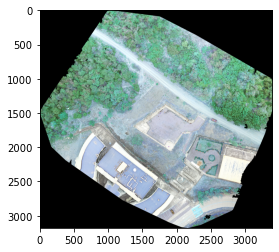

In [2]:
import rasterio
imgpath = "Mosaicos/bosqueed.tif"
dataset = rasterio.open(imgpath)
num_cluster = 2
image = cv2.imread(imgpath)
image_copy = np.copy(image)
plt.imshow(image_copy) 

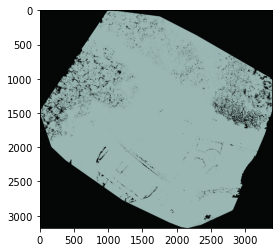

In [3]:
pixel_values = image_copy.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
stop_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
number_of_attempts = 5
centroid_initialization_strategy = cv2.KMEANS_RANDOM_CENTERS
_, labels, centers = cv2.kmeans(pixel_values,num_cluster,None,stop_criteria,number_of_attempts,centroid_initialization_strategy)
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape(image_copy.shape)
plt.imshow(segmented_image)

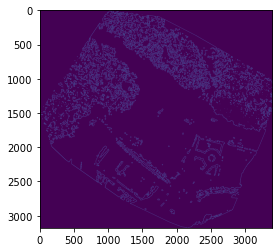

In [4]:
#edged = cv2.Canny(erosion, 0, 0)
seg = cv2.cvtColor(segmented_image,cv2.COLOR_RGB2GRAY)
kernel = np.ones((3, 3), 'uint8')
erosion = cv2.erode(seg, kernel, iterations=5)
#erosion = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)
#erosion = cv2.dilate(seg, kernel,iterations=3)
#plt.imshow(erosion)
edged = cv2.Canny(erosion, 0, 0)
_, threshold = cv2.threshold(edged, 150, 255, cv2.THRESH_BINARY_INV) 
contours, _= cv2.findContours(edged, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 
plt.imshow(edged)

In [5]:
poligono = []

#poligono.append([[[dataset.bounds.left,dataset.bounds.top,0.0],[dataset.bounds.left,dataset.bounds.bottom,0.0],
#[dataset.bounds.right,dataset.bounds.bottom,0.0],[dataset.bounds.right,dataset.bounds.top,0.0]]])

for cnt in contours : 

    approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True) 
    n = approx.ravel()  
    i = 0
    poligono1=[]
    for j in n : 
        if(i % 2 == 0): 
            x = n[i] 
            y = n[i + 1] 
            x1,y1 = dataset.xy(y, x)
            poligono1.append([x1,y1,0.0])            
        i = i + 1
    poligono.append([poligono1])

In [6]:
import fiona
from pprint import pprint
fn = 'Poligonos/test_mp2.shp'
opts = {
    'driver': 'ESRI Shapefile',
    'schema': {'geometry': '3D MultiPolygon', 'properties': {}},
    'crs' : dataset.crs
}
with fiona.open(fn, mode='w', **opts) as c:
    c.write({'geometry': {'type': 'MultiPolygon', 'coordinates': poligono}, 'properties': {}})